# Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks
This course is from Arthur Juliani [Simple Reinforcement Learning](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

### Unlike policy gradient methods, which attempt to learn functions which directly map an observation to an action, Q-Learning attempts to learn the value of being in a given state, and taking a specific action there

4x4 grid of blocks. The reward at every step is 0, except for entering the goal, which provides a reward of 1.

### we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide

### Q-Learning is a table of values for every state (row) and action (column) possible in the environment

we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values

## Bellman Equation
$$ Q(s, a) = r + \gamma (max(Q(s', a')) $$

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in.

The discount variable allows us to decide how important the possible future rewards are compared to the present reward. By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state

In [5]:
import gym
import numpy as np

In [6]:
env = gym.make('FrozenLake-v0')

In [9]:
Q = np.zeros([env.observation_space.n, env.action_space.n])

In [10]:
lr = .8
y = .95
num_episodes = 2000

In [11]:
rList = []

In [13]:
for i in range(num_episodes):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    
    while j < 99:
        j += 1
        
        a = np.argmax(Q[s, :] + np.random.randn(1, env.action_space.n) * (1./(i+1)))
        s1, r, d, _ = env.step(a)
        
        Q[s, a] = Q[s, a] + lr * (r + y*np.max(Q[s1, :]) - Q[s, a])
        rAll += r
        s = s1
        
        if d == True:
            break
        
    rList.append(rAll)

In [14]:
"Score over time: " +  str(sum(rList)/num_episodes)

'Score over time: 0.397'

In [15]:
print("Final Q-Table Values")
Q

Final Q-Table Values


array([[2.89502315e-01, 3.03911853e-03, 2.36887706e-03, 2.37470101e-03],
       [4.09119805e-04, 7.87805307e-05, 8.03189642e-05, 2.67371017e-01],
       [1.83308576e-03, 1.63346622e-03, 4.14533160e-04, 1.32924616e-01],
       [6.63670387e-05, 7.45559608e-05, 7.57368351e-06, 7.55085229e-02],
       [3.91788259e-01, 9.20494599e-04, 5.48330234e-05, 3.23414402e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.42594488e-03, 3.37176696e-05, 3.07001001e-05, 1.48182749e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.74505972e-04, 2.93529776e-04, 1.72798745e-03, 5.60183147e-01],
       [9.80431421e-04, 2.24581195e-01, 0.00000000e+00, 0.00000000e+00],
       [7.88748134e-02, 1.08836923e-05, 2.56367325e-03, 1.56310361e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.50939230e-04, 1.06348916e-03, 7.26997098e

### Scaling
By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values

### Loss 

$$ Loss = \sum (QTarget - Q) ^2 $$

### Q-Network Learning

In [17]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/seb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
env = gym.make('FrozenLake-v0')

In [19]:
tf.reset_default_graph()

In [37]:
inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_normal([16, 4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

In [38]:
nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [39]:
init = tf.global_variables_initializer()

In [40]:
y = .99
e = 0.1
num_episodes = 2000

In [41]:
jList = []
rList = []

In [42]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        while j < 99:
            j += 1
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1: np.identity(16)[s:s+1]})
            
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
                
            s1, r, d, _ = env.step(a[0])
            
            Ql = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1:s1+1]})
            
            maxQl = np.max(Ql)
            targetQ = allQ
            targetQ[0, a[0]] = r + y * maxQl
            
            _, W1 = sess.run([updateModel, W], feed_dict={inputs1: np.identity(16)[s:s+1], nextQ: targetQ})
            
            rAll += r
            s = s1
            
            if d == True:
                e = 1. / ((i/50)+10)
                break
            
        jList.append(j)
        rList.append(rAll)

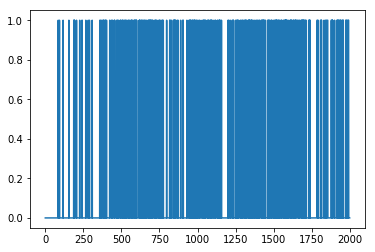

In [43]:
plt.plot(rList)

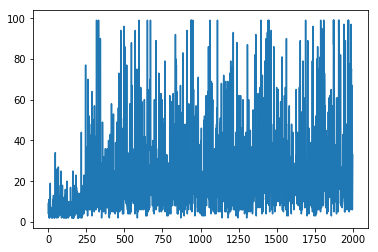

In [44]:
plt.plot(jList)